# Deconvolution with two images

In [here](http://localhost:8888/notebooks/notebooks/2018-06%20-%20Deconvolution%20with%20Consecutive%20Deconvolution%20estimates.ipynb) and here I demonstrated that applying FRC to deconvolution results is rather challenging, as the deconvolution process make cause for the two images to strongly correlate. Here I show how the deconvolution results can be successfully evaluated with FRC using the checkerboard split method.

In [78]:
%matplotlib inline

import os
import numpy as np

import supertomo.data.io.read as imread
import supertomo.ui.plots.image as showim
from supertomo.psf import psfgen
from supertomo.data.containers.image import Image
import supertomo.processing.image as imops
from supertomo.processing.deconvolution import deconvolve
from supertomo.data.messages import image_writer_wrappers as imwrap



Load *Carma* file into the internal image container class. Then generate a theoretical PSF for deconvolution.

In [79]:
# Image
data_dir = "/Users/sami/Documents/Work/Data/2018_05_FSC_paper/2018_01_29_FRC_Nikon_Taka"
image1_name = "FRC_GaAsP_AU04_.nd2"
image2_name = "FRC_GaAsP_AU04.nd2"

image1 = imread.get_image(os.path.join(data_dir, image1_name))
image2 = imread.get_image(os.path.join(data_dir, image2_name))

image1 = Image(image1 - image1.min(), image1.spacing)
image2 = Image(image2 - image2.min(), image2.spacing)

image_copy = image1.copy()
image_copy.spacing = image1.spacing
spacing = image1.spacing
print "The image dimensions are {} and spacing {} um.".format(image1.shape, image1.spacing)

The image dimensions are (512, 512) and spacing [0.05179004745018662, 0.05179004745018662] um.


Setting up registration job
Starting registration
Final metric value: -0.934373663609
Optimizer's stopping condition, RegularStepGradientDescentOptimizerv4: Step too small after 18 iterations. Current step (0.000470185) is less than minimum step (0.0005).


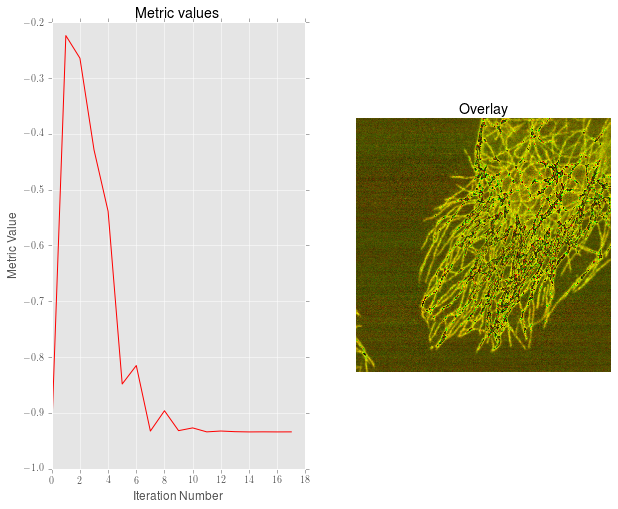

In [80]:
import supertomo.ui.supertomo_options as options
from supertomo.processing.registration import registration
from supertomo.processing import itk

fixed_image = itk.convert_to_itk_image(image1)
moving_image = itk.convert_to_itk_image(image2)


args_list = ("path --sampling-percentage=1 --reg-relax-factor=.6 --learning-rate=1 --min-step=0.0005 "         
        "--reg-max-iterations=300 --reg-method=correlation --reg-translate-only " 
        "--reg-enable-observers").split()

args = options.get_ism_script_options(args_list)

transform = registration.itk_registration_rigid_2d(fixed_image, moving_image, args)



In [81]:
image2 = itk.convert_from_itk_image(itk.resample_image(moving_image, transform))

print transform

itk::simple::Transform
 TranslationTransform (0x7ff691297870)
   RTTI typeinfo:   itk::TranslationTransform<double, 2u>
   Reference Count: 2
   Modified Time: 5289301
   Debug: Off
   Object Name: 
   Observers: 
     none
   Offset: [0.00555462, 0.00374428]



In [82]:

def get_confocal_psf(ndim, ex_wavelen=488, em_wavelen=525, na=1.45, refr_index=1.5, 
                     pinhole=.4, magnification=60, sted=False):

    psf = psfgen.PSF(psfgen.GAUSSIAN | psfgen.CONFOCAL, shape=(128,128), ex_wavelen=ex_wavelen, 
                          em_wavelen=em_wavelen, num_aperture=na, refr_index=refr_index, 
                          pinhole_radius=pinhole, magnification=magnification )
    if sted:
        psf.sted_correction()
        
    psf_image = psf.volume()
    psf_spacing = (psf.dims['um'][0]/psf.shape[0],)*3

    if ndim == 2:
        psf_image = psf_image[psf_image.shape[0]/2]
        psf_spacing = psf_spacing[:-1]

    return Image(psf_image, psf_spacing)

psf = get_confocal_psf(2)

print "Succesfully generated a theoretical PSF."
print "The image dimensions are {} and spacing {}.".format(psf.shape, psf.spacing)


Succesfully generated a theoretical PSF.
The image dimensions are (255, 255) and spacing [0.03125, 0.03125].


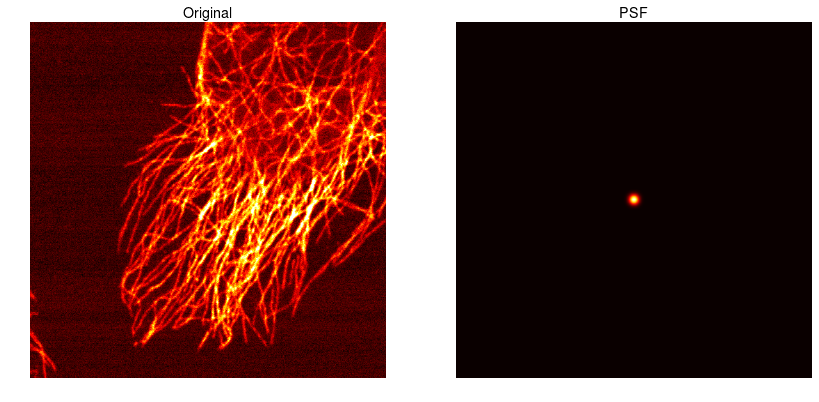

In [83]:
showim.display_2d_images(imops.enhance_contrast(image1, percent_saturated=0.3), 
                         psf,
                         image1_title="Original",
                         image2_title="PSF")



Run deconvolution

# Deconvolve Image 1

In [84]:
from supertomo.ui import deconvolution_options as options
n_iterations = 45
args_list = ("image psf"  
             " --max-nof-iterations={}  --first-estimate=image " 
             " --blocks=1 --pad=0 --save-intermediate-results --resolution-threshold-criterion=one-bit "
             " --bin-delta=14 --frc-curve-fit-degree=4 --use-splines "
             " --resolution-threshold-value=0.6").format(n_iterations).split()
            
args = options.get_deconvolve_script_options(args_list)

In [85]:
image_1_results_dir = os.path.join(data_dir, "image_1_results")
image_2_results_dir = os.path.join(data_dir, "image_2_results")

if not os.path.exists(image_1_results_dir):
    os.mkdir(image_1_results_dir)
    
writer = imwrap.TiffImageWriter(image_1_results_dir)

deconvolution_task_1 = deconvolve.DeconvolutionRL(image1, psf, writer, args)
deconvolution_task_1.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/45                ] E/S/U/N=0/21093282/14260121/0, LEAK=-0.748941737113%, TAU1=0.0518488138914, TIME=0.169s, U/ESU=0.403 
Beginning the computation of the 1. estimate
[=>                2/45                ] ETA:6.3s E/S/U/N=81/26812382/8569193/0, LEAK=-0.829458326636%, TAU1=0.0348373353481, TIME=0.142s, U/ESU=0.242 
Beginning the computation of the 2. estimate
[==>               3/45                ] ETA:6.1s E/S/U/N=0/29795634/5576758/0, LEAK=-0.803054159704%, TAU1=0.0277159269899, TIME=0.141s, U/ESU=0.158 
Beginning the computation of the 3. estimate
[==>               4/45                ] ETA:5.9s E/S/U/N=98/31307705/4051145/0, LEAK=-0.764744438726%, TAU1=0.0237155500799, TIME=0.140s, U/ESU=0.115 
Beginning the computation of the 4. estimate
[===>             5/45           

[=================41/45============>   ] ETA:647ms E/S/U/N=100/35246985/39216/0, LEAK=-0.557715762457%, TAU1=0.00849099643528, TIME=0.143s, U/ESU=1.11E-3 
Beginning the computation of the 41. estimate
[=================42/45============>   ] ETA:486ms E/S/U/N=0/35247199/39618/0, LEAK=-0.559188050341%, TAU1=0.00843561254442, TIME=0.166s, U/ESU=1.12E-3 
Beginning the computation of the 42. estimate
[=================43/45=============>  ] ETA:325ms E/S/U/N=179/35248883/38322/0, LEAK=-0.560804585867%, TAU1=0.00838319957256, TIME=0.173s, U/ESU=1.09E-3 
Beginning the computation of the 43. estimate
[=================44/45==============> ] ETA:162ms E/S/U/N=175/35251341/36485/0, LEAK=-0.562563026395%, TAU1=0.00833369791508, TIME=0.142s, U/ESU=1.03E-3 
Beginning the computation of the 44. estimate
[================45/45=================] ETA:0 E/S/U/N=89/35253271/35307/0, LEAK=-0.564459544178%, TAU1=0.00828676484525, TIME=0.199s, U/ESU=1.00E-3 
Nothing happens

[================45/45=========

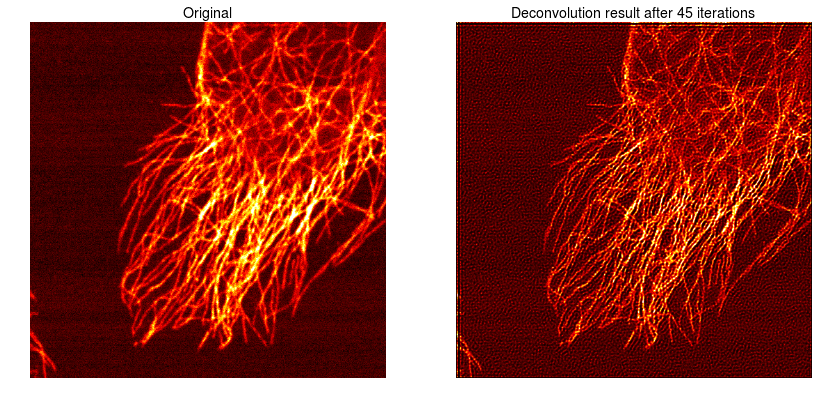

In [86]:
result = deconvolution_task_1.get_result()

showim.display_2d_images(imops.enhance_contrast(image1, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolution result after {} iterations".format(n_iterations))





## Deconvolve Image 2

In [87]:
image_2_results_dir = os.path.join(data_dir, "image_2_results")

if not os.path.exists(image_2_results_dir):
    os.mkdir(image_2_results_dir)
    
writer = imwrap.TiffImageWriter(image_2_results_dir)

deconvolution_task_2 = deconvolve.DeconvolutionRL(image2, psf, writer, args)
deconvolution_task_2.execute()

The original image size is (512, 512)
The deconvolution will be run with 1 blocks
The internal block size is (512, 512)
Preparing image fusion.
Beginning the computation of the 0. estimate
[>                 1/45                ] E/S/U/N=0/20199654/13803520/0, LEAK=-0.738576407334%, TAU1=0.0517783686519, TIME=0.209s, U/ESU=0.406 
Beginning the computation of the 1. estimate
[=>                2/45                ] ETA:8.5s E/S/U/N=0/25941872/8084589/0, LEAK=-0.807570441381%, TAU1=0.0345294997096, TIME=0.193s, U/ESU=0.238 
Beginning the computation of the 2. estimate
[==>               3/45                ] ETA:7.8s E/S/U/N=0/28837773/5177327/0, LEAK=-0.773909377389%, TAU1=0.0273426827043, TIME=0.166s, U/ESU=0.152 
Beginning the computation of the 3. estimate
[==>               4/45                ] ETA:7.6s E/S/U/N=0/30296622/3704135/0, LEAK=-0.731416234171%, TAU1=0.0233263932168, TIME=0.179s, U/ESU=0.109 
Beginning the computation of the 4. estimate
[===>             5/45             

[=================41/45============>   ] ETA:683ms E/S/U/N=98/33897434/26653/0, LEAK=-0.504564253264%, TAU1=0.00822185538709, TIME=0.176s, U/ESU=7.86E-4 
Beginning the computation of the 41. estimate
[=================42/45============>   ] ETA:517ms E/S/U/N=48/33899285/25336/0, LEAK=-0.50599942094%, TAU1=0.00816876348108, TIME=0.224s, U/ESU=7.47E-4 
Beginning the computation of the 42. estimate
[=================43/45=============>  ] ETA:344ms E/S/U/N=0/33900452/24744/0, LEAK=-0.507559066496%, TAU1=0.00811809767038, TIME=0.154s, U/ESU=7.29E-4 
Beginning the computation of the 43. estimate
[=================44/45==============> ] ETA:171ms E/S/U/N=179/33902108/23475/0, LEAK=-0.509238085134%, TAU1=0.00806990731508, TIME=0.144s, U/ESU=6.92E-4 
Beginning the computation of the 44. estimate
[================45/45=================] ETA:0 E/S/U/N=0/33903289/23079/0, LEAK=-0.51103092585%, TAU1=0.00802421942353, TIME=0.219s, U/ESU=6.80E-4 
Nothing happens

[================45/45==============

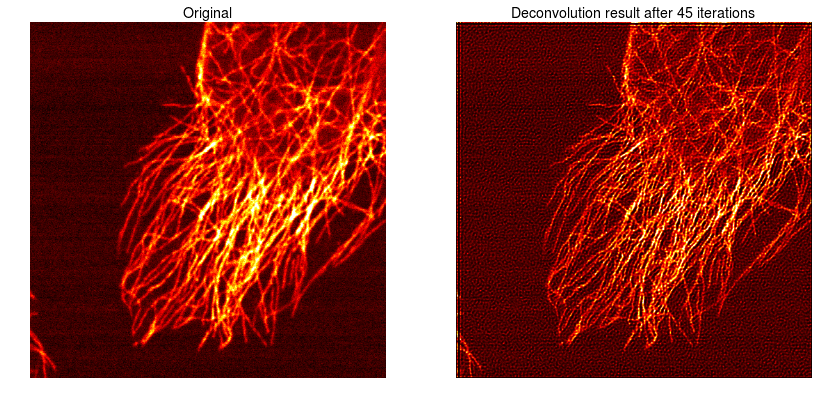

In [88]:
deconvolution_final_result = deconvolution_task_2.get_result()

showim.display_2d_images(imops.enhance_contrast(image2, percent_saturated=0.3), 
                         imops.enhance_contrast(
                             deconvolution_final_result, 
                             percent_saturated=0.3),
                             image1_title="Original",
                             image2_title="Deconvolution result after {} iterations".format(n_iterations))




## FRC analysis of the deconvolution progress

Here I analyse each of the intermediate results from the deconvolution with FRC. The dual image setting seems to be much more susceptible to deconvolution artefacts, which can be seen to appear after four iterations. Similarly to the single image case, FRC can be used to stop the deconvolution early, but a rather high threshold needs to be used, in order to not detect the structural noise as details. 

In [89]:
import supertomo.analysis.resolution.fourier_ring_correlation as frc
import supertomo.analysis.resolution.analysis as frc_analysis
import supertomo.data.io.read as read
from supertomo.data.containers.fourier_correlation_data import FourierCorrelationDataCollection
import supertomo.analysis.resolution.analysis as fsc_analysis
import supertomo.processing.image as imops
from math import sqrt
import supertomo.processing.windowing as window
frc_data = FourierCorrelationDataCollection()


for idx in range(n_iterations):
    image_name = "result_{}.tif".format(idx)

    image1_path = os.path.join(image_1_results_dir, image_name)
    image2_path = os.path.join(image_2_results_dir, image_name)


    image1 = read.get_image(image1_path)
    image2 = read.get_image(image2_path)
    
    image1 = Image(window.apply_hamming_window(image1), spacing)
    image2 = Image(window.apply_hamming_window(image2), spacing)

    frc_task = frc.FRC(image1, image2, args.d_bin)
    frc_data[idx] = frc_task.execute()
                 

analyzer = fsc_analysis.FourierCorrelationAnalysis(frc_data, spacing[0], args)
results = analyzer.execute()


Fit starts at 0.765625
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.765625
Optimization terminated successfully.
         Current function value: 0.000046
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7109375
Optimization terminated successfully.
         Current function value: 0.000044
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7109375
Optimization terminated successfully.
         Current function value: 0.000059
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7109375
Optimization terminated successfully.
         Current function value: 0.000060
         Iterations: 10
         Function evaluations: 20
Fit starts at 0.7109375
Optimization terminated successfully.
         Current function value: 0.000030
         Iterations: 11
         Function evaluations: 22
Fit starts at 0.7109375
Optimi

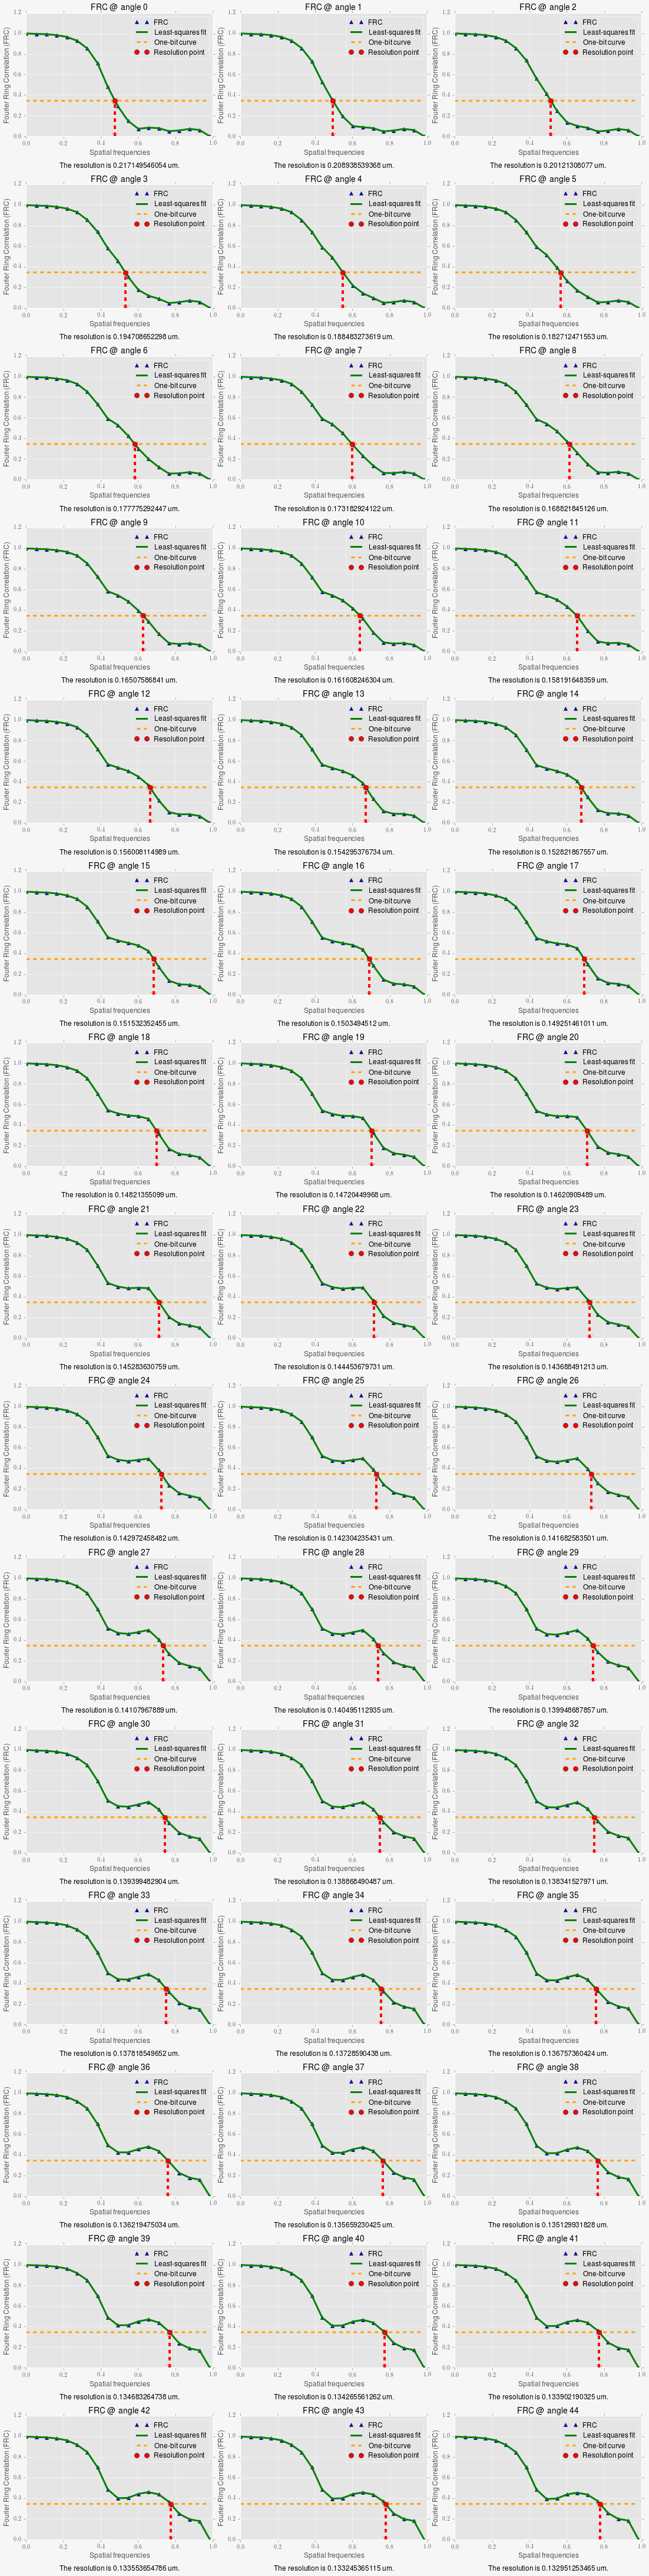

In [90]:
import supertomo.ui.plots.frc as frcplots

plotter = frcplots.FourierDataPlotter(results)
plotter.plot_all()

## Regarding the measured FRC values

I wanted to see look more closely into how the FRC values behave as a function of the iteration count. The *SuperTomo* deconvolution algorithm also calculates several parameter values that have traditionally been used to evaluate the progress of an iterative deconvolution. For more info, look at (Koho et al 2014). 

Here I normalize all the parameter values (0-1) for easy comparison and plotting. The original values are maintained in the *deconvolution_parameters* dataframe.

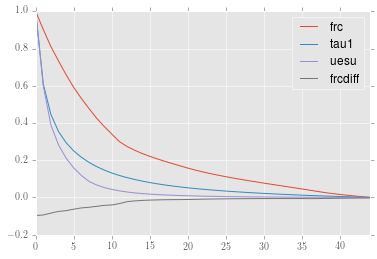

In [91]:
# Get a list of the resolution values as a function of iteration number
iterations = list()
resolutions = list()

for dataset in results:
    iterations.append(int(dataset[0]))
    resolutions.append(dataset[1].resolution["resolution"])

iterations, resolutions = zip(*sorted(zip(iterations, resolutions)))

# Get saved deconvolution parameters
deconvolution_parameters = deconvolution_task_1.progress_parameters
#deconvolution_parameters_2 = deconvolution_task_2.progress_parameters

deconvolution_parameters['frc'] = resolutions


# Set up curves
curves = deconvolution_parameters.loc[:, ['frc', 'tau1', 'uesu']]

curves['frc'] -= curves['frc'].min()
curves['frc'] /= curves['frc'].max()

curves['tau1'] -= curves['tau1'].min()
curves['tau1'] /= curves['tau1'].max()

curves['uesu'] -= curves['uesu'].min()
curves['uesu'] /= curves['uesu'].max() 

curves['frcdiff'] = np.gradient(curves['frc'])



curves.plot()

## Regarding the FRC resolution curve

The FRC resolution value curve behaves in a very interesting way. A strange shoulder appears after four iterations on the high frequency tail of the FRC spectrum. If one sets the resolution threshold to the beginning of this shoulder point, a resolution curve much like in the single image case can be achieved. However, if one considers the new shoulder to contain useful details, the effective resolution seems to go up much beyond the diffraction limit -- this of course is mostly noise, but let's take a look.

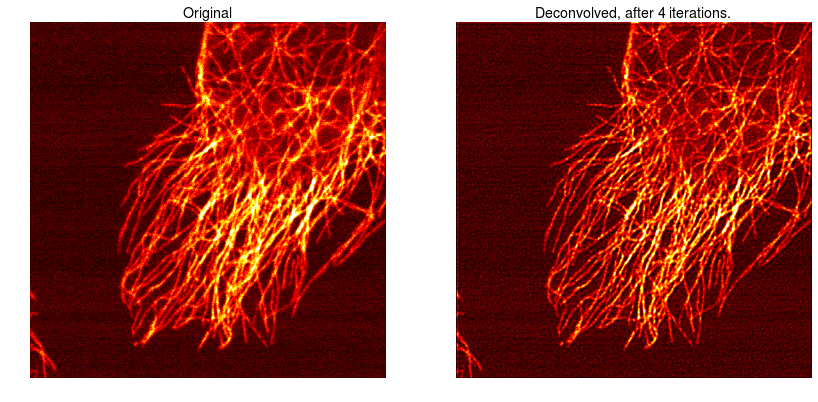

In [92]:
image_path = os.path.join(image_1_results_dir, "result_4.tif")

result_image = read.get_image(image_path)
showim.display_2d_images(imops.enhance_contrast(image_copy, percent_saturated=0.3), 
                         imops.enhance_contrast(result_image, percent_saturated=0.3),
                         image1_title="Original",
                         image2_title="Deconvolved, after {} iterations.".format(4))


## High frequency structures

I also wanted to see what is contained at the high frequencies that start to amplify very early in the deconvolution process. First I used a high-pass filter to filter out all the details below the *53% of the Nyquist threshold* that I estimated from the iteration 4 output (the last estimate to not contain the shoulder). The result is dotty, like a convolution of the PSF with a point source: the deconvolution starts to fit noise.

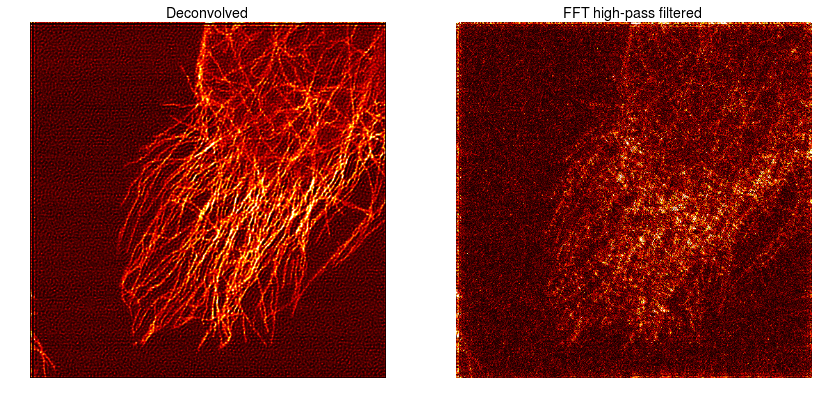

In [100]:
from supertomo.processing.fft_filters import fft_filter

threshold_point = 0.53

result = fft_filter(deconvolution_final_result, 
                    threshold_point,
                    kind='high')


showim.display_2d_images(imops.enhance_contrast(deconvolution_final_result, percent_saturated=0.3), 
                         imops.enhance_contrast(result, percent_saturated=0.3),
                         image1_title="Deconvolved",
                         image2_title="FFT high-pass filtered")



I then proceeded to use low-pass filtering to see what kind of details if any, the new shoulder contains. As can be seen the images are identical, except that the one with the 0.53 threshold is a bit less noisy, especially in spots indicated by the image above.

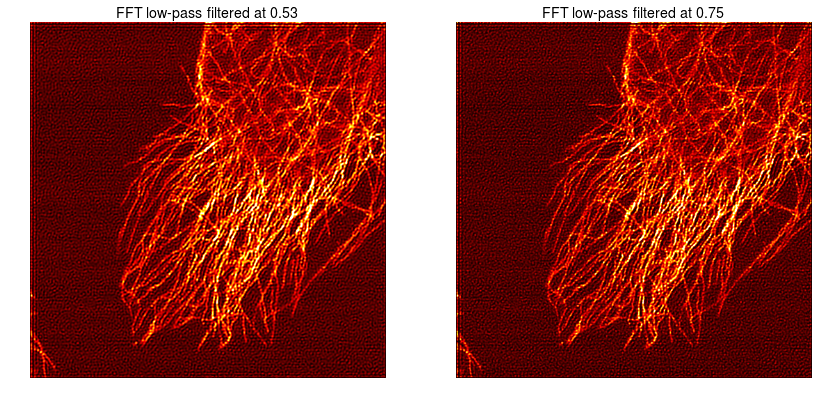

In [102]:
low_pass_result_low = fft_filter(deconvolution_final_result, 
                             .53,
                             kind='low')

low_pass_result_high = fft_filter(deconvolution_final_result, 
                             .75,
                             kind='low')

showim.display_2d_images(imops.enhance_contrast(low_pass_result_low, percent_saturated=0.3), 
                         imops.enhance_contrast(low_pass_result_high, percent_saturated=0.3),
                         image1_title="FFT low-pass filtered at 0.53",
                         image2_title="FFT low-pass filtered at 0.75")

